In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
import cv2
import skimage.io
import io

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
#train9-test
import json
for i in range(1, 3):
  filepath = "drive/MyDrive/blur_data/train"+str(i)+".json"
  print(filepath)
  dataset = json.load(open(filepath))
  if i==1:
    x_data = np.array(dataset["x_train"], dtype=np.float32)
    y_data = np.array(dataset["y_train"], dtype=np.float32)
  else:
    x_data = np.concatenate((x_data, np.array(dataset["x_train"], dtype=np.float32)),axis=0)
    y_data = np.concatenate((y_data, np.array(dataset["y_train"], dtype=np.float32)),axis=0)
print(x_data.shape, y_data.shape)

drive/MyDrive/blur_data/train1.json
drive/MyDrive/blur_data/train2.json
(6000, 64, 64, 3) (6000,)


In [44]:
folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = y_data[train_indices]

x_val = x_data[val_indices]
y_val = y_data[val_indices]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(4800, 64, 64, 3) (4800,)
(1200, 64, 64, 3) (1200,)


In [45]:
y_train

array([1., 1., 0., ..., 0., 1., 1.], dtype=float32)

# **Define AlexNET**

In [46]:
# -*- coding: utf-8 -*-
"""Alexnet_CNN.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Qof1q73U_X_Z3HIt8CAk6oBxi110jabU

Alexnet CNN
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold


import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

class Alexnet(tf.keras.Model):
  def __init__(self):
    super(Alexnet, self).__init__()
    self.input1 = tf.keras.layers.InputLayer(input_shape=(64, 64, 3))
    
    #Strides of 4 to rdeuce size
    self.conv1 = tf.keras.layers.Conv2D(filters=96, kernel_size=(10,10), strides=1, activation='relu')
    self.norm1 = BatchNormalization()
    self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2)
    
    #make window smaller, set padding to 2 for consistent height/width
    self.conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=2, padding='same', activation='relu')
    self.norm2 = BatchNormalization()
    self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2)
       
    #Thre successive convolutional layer and a smaller convolution window
    self.conv3 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')
    self.norm3 = BatchNormalization()
    self.conv4 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')
    self.norm4 = BatchNormalization()
    self.conv5 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')
    self.norm5 = BatchNormalization()
    
    #reduce dimensionality
    self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2)


    #Fully Connected Layer
    self.flat = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop1 = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop2 = tf.keras.layers.Dropout(0.5)
    self.out = tf.keras.layers.Dense(units=10)

    #prediction
    self.last = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
  def call(self, input):
    x = self.input1(input)
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.norm3(x)
    x = self.conv4(x)
    x = self.norm4(x)
    x = self.conv5(x)
    x = self.norm5(x)
    x = self.pool3(x)
    x = self.flat(x)
    x = self.dense1(x)
    x = self.drop1(x)
    x = self.dense2(x)
    x = self.drop2(x)
    x = self.out(x)
    x = self.last(x)
    return x
  
model = Alexnet()


In [47]:
model.compile(optimizer='adam',  # pick an optimizer
              loss='binary_crossentropy',  # pick a loss
              metrics=['accuracy'])  # pick a metric to monitor

In [48]:
result = model.fit(x_train, y_train, epochs=13, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/13
150/150 [==============================] - 286s 2s/step - loss: 1.3896 - accuracy: 0.7669 - val_loss: 0.4665 - val_accuracy: 0.7842
Epoch 2/13
150/150 [==============================] - 284s 2s/step - loss: 0.3905 - accuracy: 0.8500 - val_loss: 0.6077 - val_accuracy: 0.8625
Epoch 3/13
150/150 [==============================] - 285s 2s/step - loss: 0.3484 - accuracy: 0.8708 - val_loss: 0.6989 - val_accuracy: 0.6933
Epoch 4/13
150/150 [==============================] - 282s 2s/step - loss: 0.3519 - accuracy: 0.8865 - val_loss: 0.4737 - val_accuracy: 0.7850
Epoch 5/13
150/150 [==============================] - 283s 2s/step - loss: 0.3287 - accuracy: 0.8769 - val_loss: 0.9088 - val_accuracy: 0.7967
Epoch 6/13
150/150 [==============================] - 281s 2s/step - loss: 0.2481 - accuracy: 0.9158 - val_loss: 9.3903 - val_accuracy: 0.4467
Epoch 7/13
150/150 [==============================] - 282s 2s/step - loss: 0.3075 - accuracy: 0.8990 - val_loss: 0.2715 - val_accuracy: 0.8833

In [19]:
# model.save('drive/MyDrive/blur_data/noise-model.model')

INFO:tensorflow:Assets written to: drive/MyDrive/blur_data/noise-model.model/assets


In [ ]:
# model = tf.keras.models.load_model('drive/MyDrive/non-blur-data/non-noise-model.model')
# result = model.fit(x_train, y_train, epochs=13, batch_size=32, validation_data=(x_val, y_val))

In [49]:
model.summary()

Model: "alexnet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  28896     
_________________________________________________________________
batch_normalization_5 (Batch multiple                  384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  614656    
_________________________________________________________________
batch_normalization_6 (Batch multiple                  1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0 

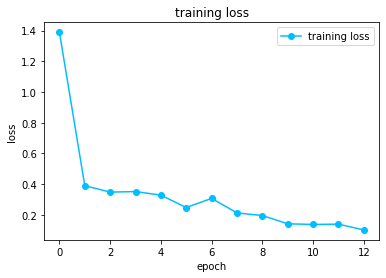

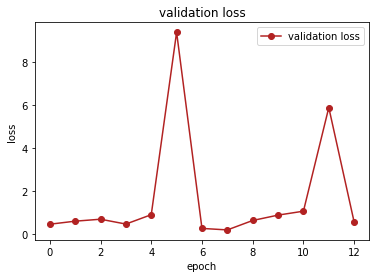

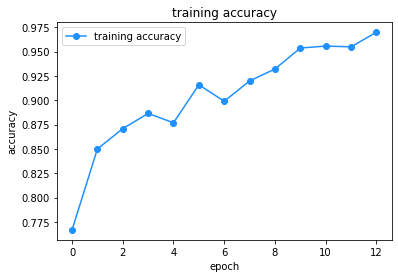

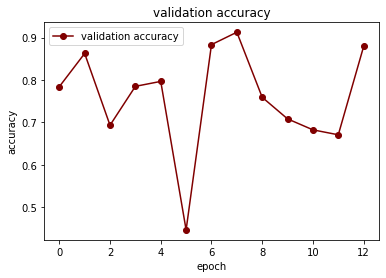

In [50]:
plt.figure(1)
p1=plt.plot(result.history['loss'],marker = "o",color = 'deepskyblue' )
plt.legend((p1), ("training loss",))
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.figure(2)
p2=plt.plot(result.history['val_loss'], marker = "o", color = 'firebrick')
plt.legend((p2),("validation loss",))
plt.title('validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.figure(3)
p3=plt.plot(result.history['accuracy'],marker = "o", color = 'dodgerblue')
plt.legend((p3),("training accuracy",))
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure(4)
p4=plt.plot(result.history['val_accuracy'],marker = "o", color = 'maroon')
plt.legend((p4),("validation accuracy",))
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [57]:
y_pred = model.predict(x_val, batch_size=2, verbose=1)
print(type(y_pred))

600/600 [==============================] - 28s 46ms/step
<class 'numpy.ndarray'>


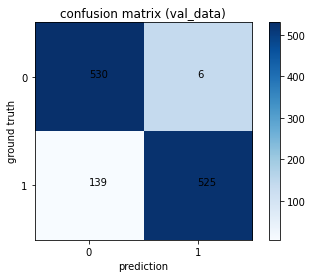

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ry_val = []
ry_pred = []

for tlabel in y_val:
  if tlabel>=0.5:
    ry_val.append(1)
    continue
  ry_val.append(0)
ry_val = np.array(ry_val)
for plabel in y_pred:
  if plabel>=0.5:
    ry_pred.append(1)
    continue
  ry_pred.append(0)
ry_pred = np.array(ry_pred)

classes = list(set(ry_val))
classes.sort()
confusion = confusion_matrix(ry_pred, ry_val)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('ground truth')
plt.title('confusion matrix (val_data)')
for first_index in range(len(confusion)):
  for second_index in range(len(confusion[first_index])):
    plt.text(first_index, second_index, confusion[first_index][second_index])

plt.show()

In [52]:
filepath = "drive/MyDrive/blur_data/train9.json"
print(filepath)
dataset = json.load(open(filepath))
x_test = np.array(dataset["x_train"], dtype=np.float32)
y_test = np.array(dataset["y_train"], dtype=np.float32)

drive/MyDrive/blur_data/train9.json


In [60]:
y_pred = model.predict(x_test, batch_size=2, verbose=1)
print(type(y_pred))

1155/1155 [==============================] - 58s 50ms/step
<class 'numpy.ndarray'>


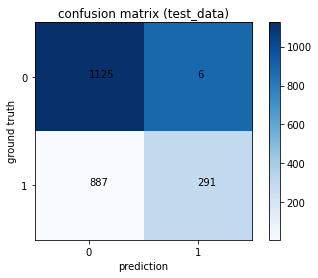

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ry_test = []
ry_pred = []

for tlabel in y_test:
  if tlabel>=0.5:
    ry_test.append(1)
    continue
  ry_test.append(0)
ry_test = np.array(ry_test)
for plabel in y_pred:
  if plabel>=0.5:
    ry_pred.append(1)
    continue
  ry_pred.append(0)
ry_pred = np.array(ry_pred)

classes = list(set(ry_test))
classes.sort()
confusion = confusion_matrix(ry_pred, ry_test)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('prediction')
plt.ylabel('ground truth')
plt.title('confusion matrix (test_data)')
for first_index in range(len(confusion)):
  for second_index in range(len(confusion[first_index])):
    plt.text(first_index, second_index, confusion[first_index][second_index])

plt.show()